<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/GANaugment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Augmentation

Predictors used:

* Decsion Tree
* Gradient Booster
* Neural Network
* LSTM


In [1]:
!pip install lasio
!pip install md_toc
!pip install tensorflow
!pip install tensorflow-addons
!pip install smogn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 740.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

from sklearn.svm import OneClassSVM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam

from keras import layers
from keras import models

import tensorflow as tf
from tqdm import tqdm

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Fetching Data

In [4]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git

Cloning into 'Volve-Well-Log-Prediction'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 98 (delta 37), reused 9 (delta 3), pack-reused 0
Receiving objects: 100% (98/98), 45.04 MiB | 19.37 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [5]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepareing Data

In [6]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [7]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


In [8]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

## Data Transformation and Normalization

In [9]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.189869,-1.367969,0.837247,-0.816586,-1.441155,-2.286221,1.367432,15_9-F-11A,2600.4


## Outlier Removal

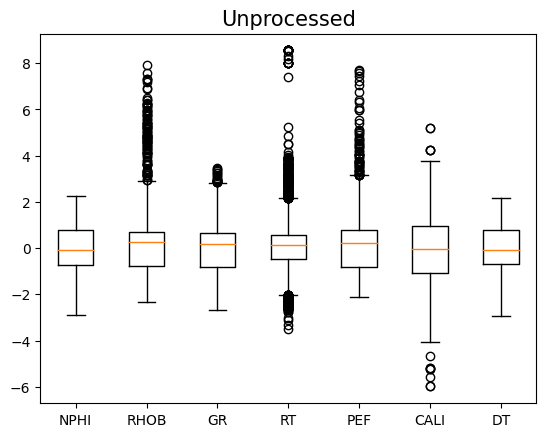

n samples unprocessed: 24403


In [10]:
# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

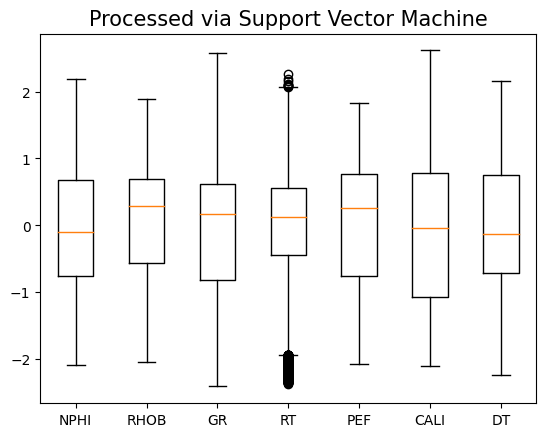

Remaining samples: 21964


In [11]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Processed via Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [12]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


## Train and Validation Prep

In [13]:
# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values.astype('float32')
y_train = train_svm[target_name].values.reshape(-1, 1).astype('float32')

# Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
    # Split the df by log name
    val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]].copy()

    # Drop name column
    val.drop(['WELL'], axis=1, inplace=True)

    # Define X_val (feature) and y_val (target) as NumPy arrays
    X_val_ = val[feature_names].values.astype('float32')
    y_val_ = val[target_name].values.reshape(-1, 1).astype('float32')

    X_val.append(X_val_)
    y_val.append(y_val_)

# Save into separate NumPy arrays
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

In [14]:
X_train = X_train.astype('float32')

# Cast y_train to float32
y_train = y_train.astype('float32')

# Cast X_val1, X_val3, X_val4 to float32
X_val1 = X_val1.astype('float32')
X_val3 = X_val3.astype('float32')
X_val4 = X_val4.astype('float32')

# Cast y_val1, y_val3, y_val4 to float32
y_val1 = y_val1.astype('float32')
y_val3 = y_val3.astype('float32')
y_val4 = y_val4.astype('float32')

# Data Augmentation

In [15]:
# Select columns for features (X) and target (y)
train_total = pd.merge(train_svm, train_trans, on = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'], how='left')
train_gen = train_svm.copy()

In [16]:
train_total.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.196481,-1.480908,0.579649,-0.636556,-1.495447,-2.108307,1.243336,15_9-F-11A,2600.6


In [17]:
train_gen.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934
6,1.196481,-1.480908,0.579649,-0.636556,-1.495447,-2.108307,1.243336


In [18]:
train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

df_gen1 = train_total[train_total['WELL'] == '15_9-F-11A'].copy()
df_gen3 = train_total[train_total['WELL'] == '15_9-F-1A'].copy()
df_gen4 = train_total[train_total['WELL'] == '15_9-F-1B'].copy()

In [19]:
# Fit and transform the 'DEPTH' column for df_gen1
df_gen1['DEPTH'] = scaler.fit_transform(df_gen1[['DEPTH']])

# Fit and transform the 'DEPTH' column for df_gen3
df_gen3['DEPTH'] = scaler.fit_transform(df_gen3[['DEPTH']])

# Fit and transform the 'DEPTH' column for df_gen4
df_gen4['DEPTH'] = scaler.fit_transform(df_gen4[['DEPTH']])

In [20]:
df_gen1.drop(columns = 'WELL').astype('float32').describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,DEPTH
count,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,1.022800e+04
mean,-0.112095,-0.003497,-0.274721,0.056440,0.292885,0.118036,-0.094888,2.386983e-08
std,0.992792,0.944150,0.921068,0.916372,0.998347,0.859239,1.046198,1.000049e+00
min,-2.063082,-2.048020,-2.410065,-2.362914,-1.802307,-2.108307,-2.230961,-1.770311e+00
25%,-0.881575,-0.800520,-0.988074,-0.233863,-0.365790,-0.046527,-0.872950,-8.330449e-01
50%,-0.276245,0.320521,-0.268374,0.237194,0.713391,-0.046527,-0.341816,8.247164e-03
75%,0.719418,0.724360,0.373959,0.662223,1.113527,0.964887,0.827411,8.489204e-01
max,2.159336,1.725365,2.386178,2.267929,1.826932,2.615518,2.152846,1.772531e+00


In [21]:
# Define the GAN model architecture
def build_generator(latent_dim, num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(64, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(256, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(num_features, activation='linear'))  # Output layer
    return model

def build_discriminator(num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_shape=(num_features,), activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer
    return model


In [22]:
generator_loss_fn =  tf.keras.losses.BinaryFocalCrossentropy()
discriminator_loss =  tf.keras.losses.BinaryFocalCrossentropy()


In [23]:
def train_gan(generator, discriminator, epochs, batch_size, data_frame, generator_optimizer, discriminator_optimizer):
    data_frame = data_frame

    # Determine the number of batches
    num_samples = len(data_frame)
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        avg_gen_loss = 0
        avg_disc_loss = 0
        with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:

            for batch in range(num_batches):

                # Get real data for the current batch
                batch_start = batch * batch_size
                batch_end = (batch + 1) * batch_size
                real_data = data_frame.iloc[batch_start:batch_end]
                real_data = real_data.values.astype('float32')

                # Sample random noise for generator input
                noise = np.random.uniform(-1, 1, size=(len(real_data), latent_dim))

                # Generate synthetic data
                generated_data = generator.predict(noise,  verbose=0)

                # Combine real and generated data
                x_combined = np.concatenate([real_data, generated_data])

                # Labels for real and generated data
                y_real = np.ones((batch_size, 1))
                y_generated = np.zeros((batch_size, 1))
                y_combined = np.concatenate([y_real, y_generated])

                # Train discriminator
                with tf.GradientTape() as disc_tape:
                    # Forward pass: compute logits for real and fake samples
                    real_logits = discriminator(real_data, training=True)
                    fake_logits = discriminator(generated_data, training=True)

                    # Compute discriminator loss
                    real_labels = tf.ones_like(real_logits)
                    fake_labels = tf.zeros_like(fake_logits)
                    discriminator_loss_real = discriminator_loss(real_labels, real_logits)
                    discriminator_loss_fake = discriminator_loss(fake_labels, fake_logits)
                    discriminator_loss_total = (discriminator_loss_real + discriminator_loss_fake)

                # Compute gradients of discriminator loss with respect to discriminator trainable variables
                gradients_of_discriminator = disc_tape.gradient(discriminator_loss_total, discriminator.trainable_variables)

                # Update discriminator weights using optimizer
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

                with tf.GradientTape() as gen_tape:
                    # Generate fake samples using the generator
                    fake_samples = generator(noise, training=True)

                    # Compute generator loss
                    generator_loss = generator_loss_fn(real_labels, discriminator(fake_samples, training=True))

                # Compute gradients of generator loss with respect to generator trainable variables
                gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)

                # Update generator weights using optimizer
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

                avg_disc_loss += discriminator_loss_total
                avg_gen_loss +=  generator_loss

                pbar.update(1)

            # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {avg_disc_loss/num_batches}, Generator Loss: {avg_gen_loss/num_batches}")


In [24]:
# Generate synthetic data for certain depths
def generate_synthetic_data(generator, num_samples):
    noise = np.random.uniform(-1, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data


In [29]:
# Train the GAN
# Define GAN components

latent_dim = 128

num_features = len(train_gen.columns)

generator_1 = build_generator(latent_dim, num_features)
discriminator_1 = build_discriminator(num_features)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

epochs = 32
batch_size = 1024 #4096
num_batches = len(train_gen) // batch_size
train_gan(generator_1, discriminator_1, epochs, batch_size, train_gen, generator_optimizer, discriminator_optimizer)

Epoch 1/32: 100%|██████████| 21/21 [00:17<00:00,  1.21batch/s]


Epoch 1/32, Discriminator Loss: 0.8188832402229309, Generator Loss: 0.3535488545894623


Epoch 2/32: 100%|██████████| 21/21 [00:13<00:00,  1.59batch/s]


Epoch 2/32, Discriminator Loss: 0.6909394264221191, Generator Loss: 0.2813882827758789


Epoch 3/32: 100%|██████████| 21/21 [00:13<00:00,  1.59batch/s]


Epoch 3/32, Discriminator Loss: 0.6218897700309753, Generator Loss: 0.2521737515926361


Epoch 4/32: 100%|██████████| 21/21 [00:14<00:00,  1.46batch/s]


Epoch 4/32, Discriminator Loss: 0.5837446451187134, Generator Loss: 0.24010726809501648


Epoch 5/32: 100%|██████████| 21/21 [00:21<00:00,  1.05s/batch]


Epoch 5/32, Discriminator Loss: 0.556672215461731, Generator Loss: 0.23312298953533173


Epoch 6/32: 100%|██████████| 21/21 [00:15<00:00,  1.40batch/s]


Epoch 6/32, Discriminator Loss: 0.53437739610672, Generator Loss: 0.22470928728580475


Epoch 7/32: 100%|██████████| 21/21 [00:15<00:00,  1.34batch/s]


Epoch 7/32, Discriminator Loss: 0.5146631598472595, Generator Loss: 0.2201923131942749


Epoch 8/32: 100%|██████████| 21/21 [00:14<00:00,  1.49batch/s]


Epoch 8/32, Discriminator Loss: 0.49981430172920227, Generator Loss: 0.2150193154811859


Epoch 9/32: 100%|██████████| 21/21 [00:13<00:00,  1.56batch/s]


Epoch 9/32, Discriminator Loss: 0.4873693883419037, Generator Loss: 0.21143797039985657


Epoch 10/32: 100%|██████████| 21/21 [00:13<00:00,  1.57batch/s]


Epoch 10/32, Discriminator Loss: 0.475334495306015, Generator Loss: 0.20638009905815125


Epoch 11/32: 100%|██████████| 21/21 [00:13<00:00,  1.55batch/s]


Epoch 11/32, Discriminator Loss: 0.465399831533432, Generator Loss: 0.2032453864812851


Epoch 12/32: 100%|██████████| 21/21 [00:13<00:00,  1.56batch/s]


Epoch 12/32, Discriminator Loss: 0.4582977890968323, Generator Loss: 0.20077207684516907


Epoch 13/32: 100%|██████████| 21/21 [00:14<00:00,  1.46batch/s]


Epoch 13/32, Discriminator Loss: 0.450031042098999, Generator Loss: 0.19756273925304413


Epoch 14/32: 100%|██████████| 21/21 [00:13<00:00,  1.53batch/s]


Epoch 14/32, Discriminator Loss: 0.4448453485965729, Generator Loss: 0.1964201182126999


Epoch 15/32: 100%|██████████| 21/21 [00:13<00:00,  1.54batch/s]


Epoch 15/32, Discriminator Loss: 0.4386022686958313, Generator Loss: 0.19372445344924927


Epoch 16/32: 100%|██████████| 21/21 [00:13<00:00,  1.54batch/s]


Epoch 16/32, Discriminator Loss: 0.4343980550765991, Generator Loss: 0.19234053790569305


Epoch 17/32: 100%|██████████| 21/21 [00:13<00:00,  1.52batch/s]


Epoch 17/32, Discriminator Loss: 0.429187536239624, Generator Loss: 0.19031694531440735


Epoch 18/32: 100%|██████████| 21/21 [00:13<00:00,  1.56batch/s]


Epoch 18/32, Discriminator Loss: 0.4253883361816406, Generator Loss: 0.18910248577594757


Epoch 19/32: 100%|██████████| 21/21 [00:14<00:00,  1.48batch/s]


Epoch 19/32, Discriminator Loss: 0.4221484363079071, Generator Loss: 0.18823876976966858


Epoch 20/32: 100%|██████████| 21/21 [00:13<00:00,  1.59batch/s]


Epoch 20/32, Discriminator Loss: 0.41858741641044617, Generator Loss: 0.18687492609024048


Epoch 21/32: 100%|██████████| 21/21 [00:13<00:00,  1.50batch/s]


Epoch 21/32, Discriminator Loss: 0.415654718875885, Generator Loss: 0.18600445985794067


Epoch 22/32: 100%|██████████| 21/21 [00:13<00:00,  1.59batch/s]


Epoch 22/32, Discriminator Loss: 0.41322579979896545, Generator Loss: 0.18542349338531494


Epoch 23/32: 100%|██████████| 21/21 [00:13<00:00,  1.55batch/s]


Epoch 23/32, Discriminator Loss: 0.4111733138561249, Generator Loss: 0.1848035603761673


Epoch 24/32: 100%|██████████| 21/21 [00:13<00:00,  1.56batch/s]


Epoch 24/32, Discriminator Loss: 0.4085884690284729, Generator Loss: 0.18397074937820435


Epoch 25/32: 100%|██████████| 21/21 [00:13<00:00,  1.59batch/s]


Epoch 25/32, Discriminator Loss: 0.4061930477619171, Generator Loss: 0.18311193585395813


Epoch 26/32: 100%|██████████| 21/21 [00:13<00:00,  1.53batch/s]


Epoch 26/32, Discriminator Loss: 0.40451908111572266, Generator Loss: 0.18282443284988403


Epoch 27/32: 100%|██████████| 21/21 [00:13<00:00,  1.54batch/s]


Epoch 27/32, Discriminator Loss: 0.4026023745536804, Generator Loss: 0.18237367272377014


Epoch 28/32: 100%|██████████| 21/21 [00:14<00:00,  1.46batch/s]


Epoch 28/32, Discriminator Loss: 0.40070247650146484, Generator Loss: 0.18182779848575592


Epoch 29/32: 100%|██████████| 21/21 [00:13<00:00,  1.59batch/s]


Epoch 29/32, Discriminator Loss: 0.39931392669677734, Generator Loss: 0.18160422146320343


Epoch 30/32: 100%|██████████| 21/21 [00:14<00:00,  1.47batch/s]


Epoch 30/32, Discriminator Loss: 0.39772409200668335, Generator Loss: 0.1813587099313736


Epoch 31/32: 100%|██████████| 21/21 [00:13<00:00,  1.58batch/s]


Epoch 31/32, Discriminator Loss: 0.39609768986701965, Generator Loss: 0.18072663247585297


Epoch 32/32: 100%|██████████| 21/21 [00:13<00:00,  1.57batch/s]

Epoch 32/32, Discriminator Loss: 0.3948596715927124, Generator Loss: 0.1805538684129715


In [39]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_1 = generate_synthetic_data(generator_1, int(len(df_gen1)*0.33))

106/106 [==============================] - 0s 2ms/step


In [40]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_3 = generate_synthetic_data(generator_1, int(len(df_gen3)*0.33))

95/95 [==============================] - 0s 2ms/step


In [41]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_4 = generate_synthetic_data(generator_1, int(len(df_gen4)*0.33))

27/27 [==============================] - 0s 2ms/step


In [42]:
columns = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

synthetic_df_1 = pd.DataFrame(synthetic_data_1, columns=columns)
synthetic_df_3 = pd.DataFrame(synthetic_data_3, columns=columns)
synthetic_df_4 = pd.DataFrame(synthetic_data_4, columns=columns)


In [44]:
from sklearn.ensemble import GradientBoostingRegressor
boosters = {}

# Train gradient boosters for each well
for well_name, df_gen in zip(train_well_names, [df_gen1, df_gen3, df_gen4]):
    # Filter data for the current well
    # df_gen = train_total[train_total['WELL'] == well_name].copy()

    # Define features (X) and target (y)
    X = df_gen.drop(columns=['DEPTH', 'WELL'])  # Assuming 'DEPTH' and 'WELL' are not features
    y = df_gen['DEPTH']

    # Train gradient booster
    booster = GradientBoostingRegressor()
    booster.fit(X, y)

    # Store trained booster in the dictionary
    boosters[well_name] = booster

# Use trained boosters to predict 'DEPTH' values for synthetic data frames
for synthetic_df, well_name in zip([synthetic_df_1, synthetic_df_3, synthetic_df_4], train_well_names):
    # Get corresponding booster for the well
    booster = boosters[well_name]

    # Predict 'DEPTH' values for synthetic data
    synthetic_df['DEPTH'] = booster.predict(synthetic_df)

In [47]:
scaler.fit(train_total[train_total['WELL'] == '15_9-F-11A']['DEPTH'].values.reshape(-1, 1))
df_gen1['DEPTH'] = scaler.inverse_transform(df_gen1['DEPTH'].values.reshape(-1, 1))
synthetic_df_1['DEPTH'] = scaler.inverse_transform(synthetic_df_1['DEPTH'].values.reshape(-1, 1))

scaler.fit(train_total[train_total['WELL'] == '15_9-F-1A']['DEPTH'].values.reshape(-1, 1))
df_gen3['DEPTH'] = scaler.inverse_transform(df_gen3['DEPTH'].values.reshape(-1, 1))
synthetic_df_3['DEPTH'] = scaler.inverse_transform(synthetic_df_3['DEPTH'].values.reshape(-1, 1))


scaler.fit(train_total[train_total['WELL'] == '15_9-F-1B']['DEPTH'].values.reshape(-1, 1))
df_gen4['DEPTH'] = scaler.inverse_transform(df_gen4['DEPTH'].values.reshape(-1, 1))
synthetic_df_4['DEPTH'] = scaler.inverse_transform(synthetic_df_4['DEPTH'].values.reshape(-1, 1))


In [49]:
def exponential_smoothing(series, alpha):
    smoothed_series = series.copy()
    for i in range(1, len(series)):
        smoothed_series[i] = alpha * series[i] + (1 - alpha) * smoothed_series[i - 1]
    return smoothed_series


In [50]:
# Define alpha for exponential smoothing (adjust as needed)
alpha = 0.2

# Apply sorting and exponential smoothing for each DataFrame
for synthetic_df in [synthetic_df_1, synthetic_df_3, synthetic_df_4]:
    synthetic_df.sort_values(by='DEPTH', inplace=True)
    for column in synthetic_df.columns:
        if column != 'WELL':  # Skip the 'WELL' column
            synthetic_df[column] = exponential_smoothing(synthetic_df[column], alpha)

In [51]:
synthetic_df_1['WELL'] = '15_9-F-11A'
synthetic_df_3['WELL'] = '15_9-F-1A'
synthetic_df_4['WELL'] = '15_9-F-1B'

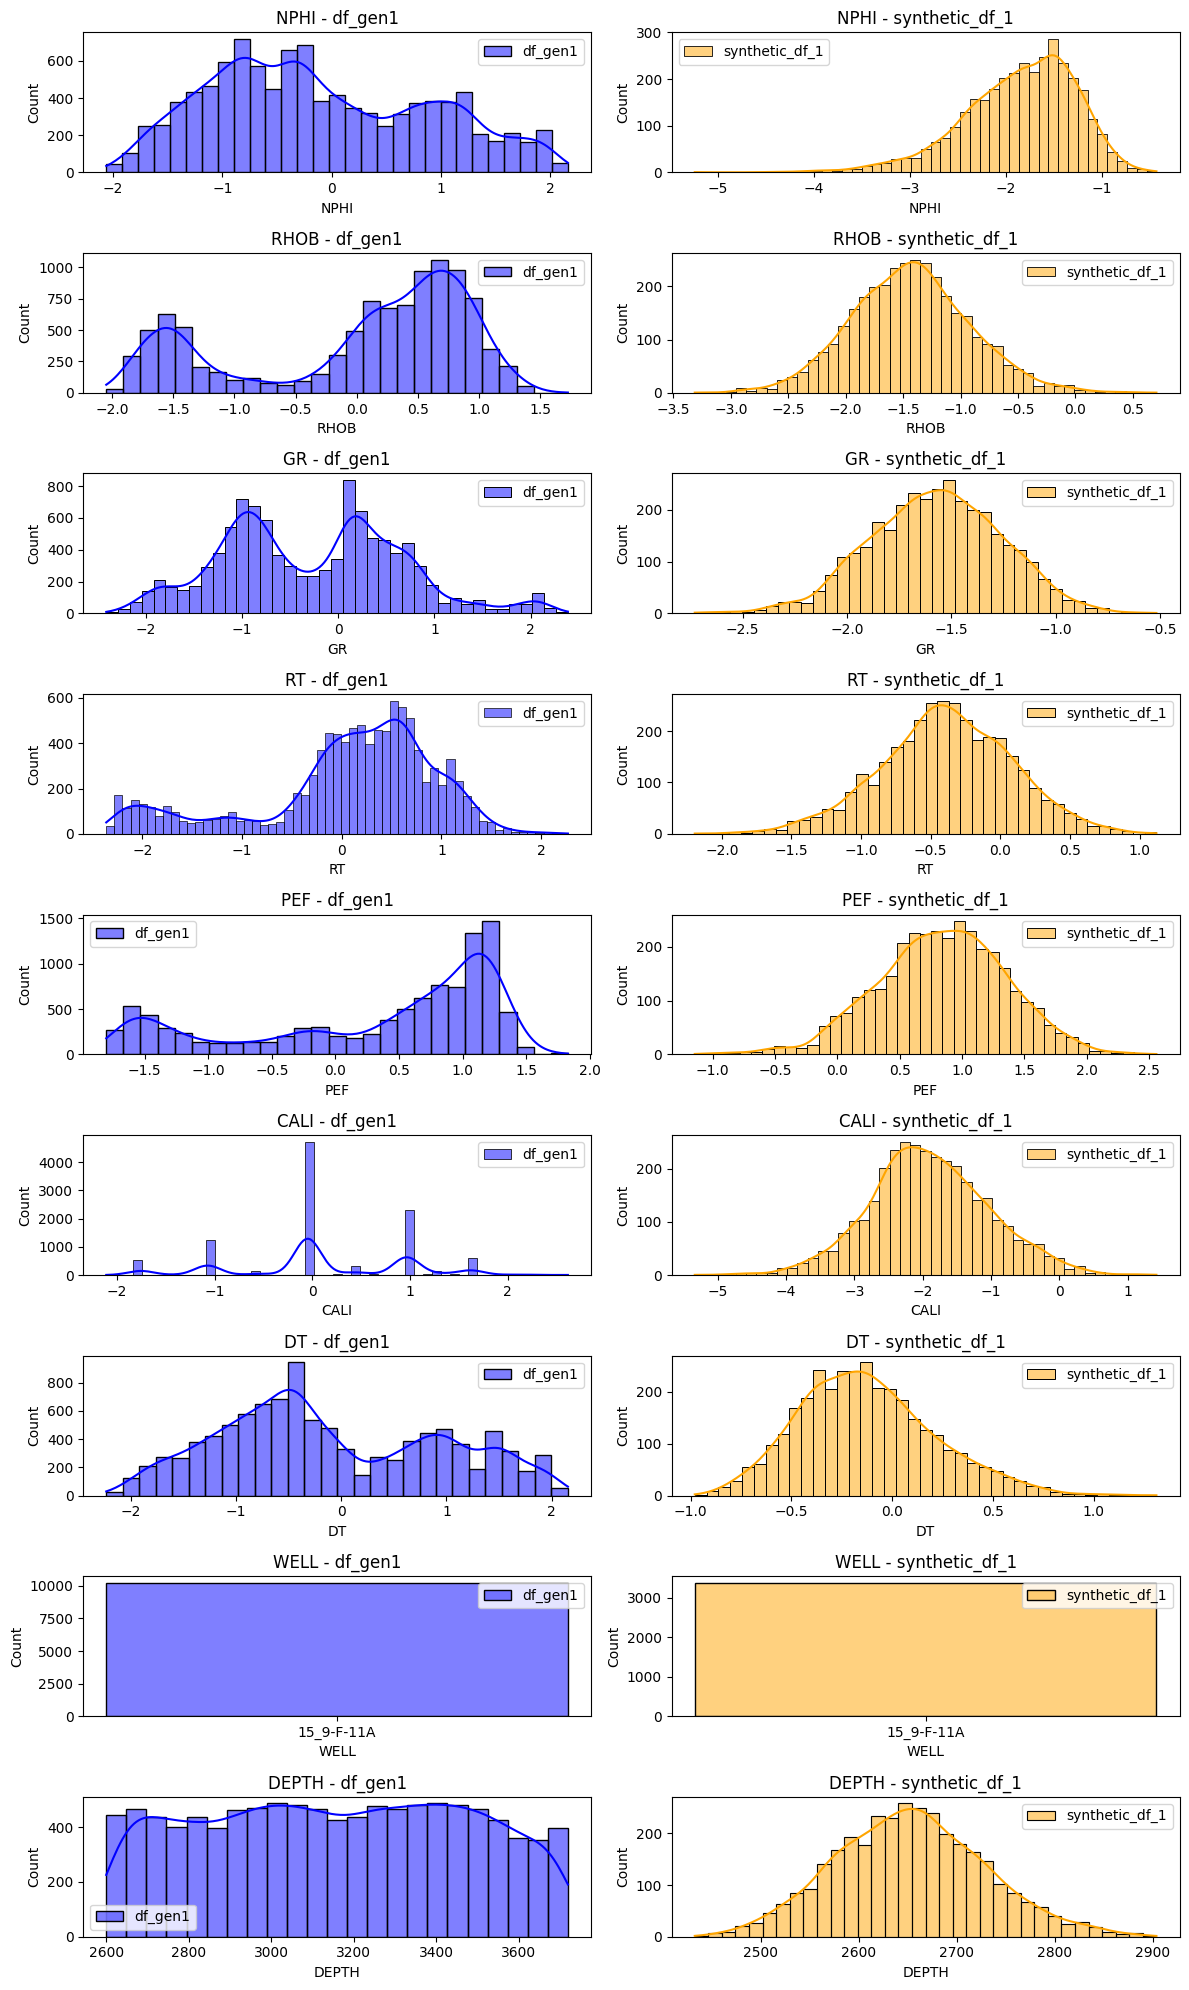

In [52]:
fig, axes = plt.subplots(nrows=len(df_gen1.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_1
for i, column in enumerate(df_gen1.columns):
    sns.histplot(df_gen1[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen1')
    axes[i, 0].set_title(f'{column} - df_gen1')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_1[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_1')
    axes[i, 1].set_title(f'{column} - synthetic_df_1')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

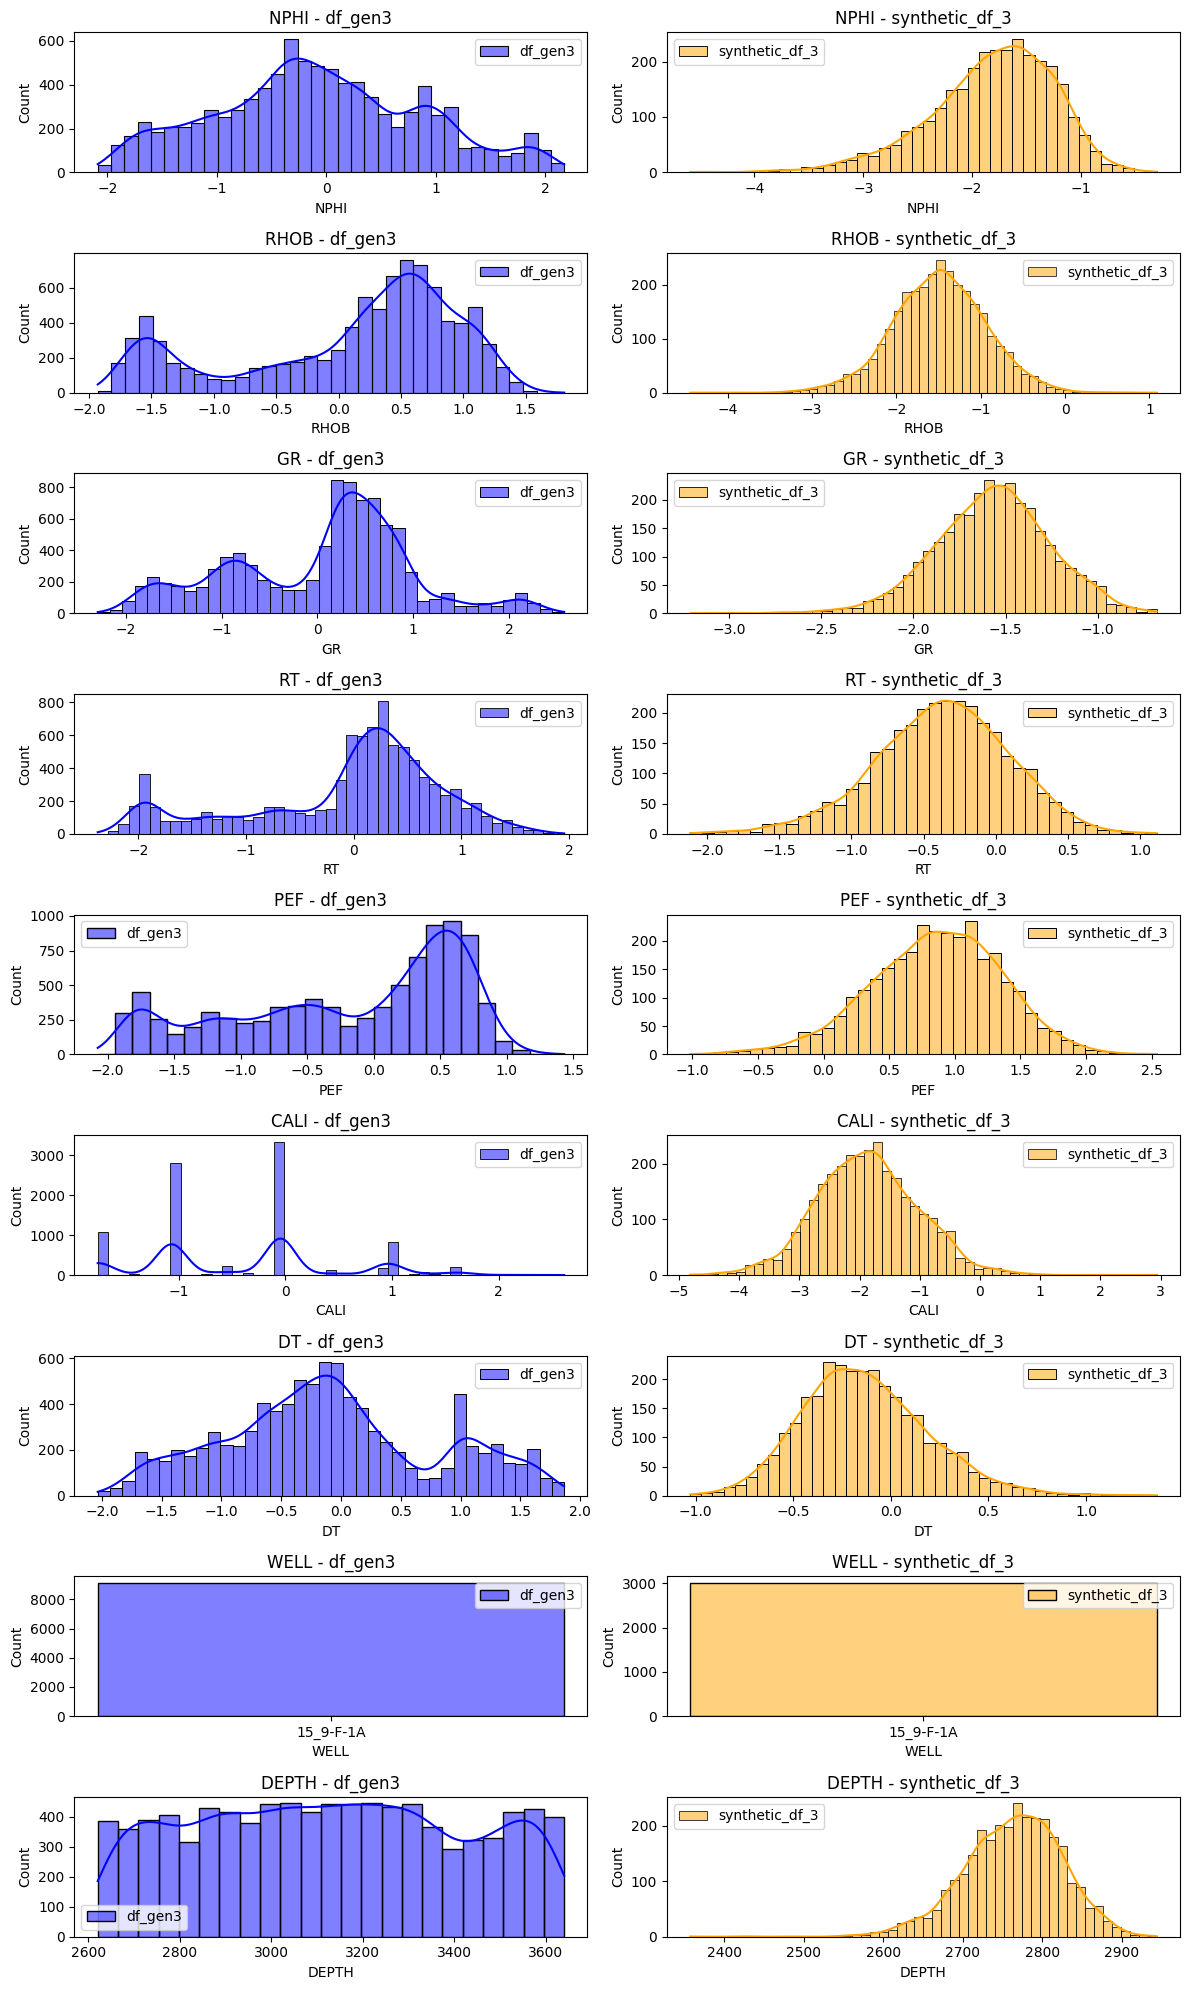

In [53]:
fig, axes = plt.subplots(nrows=len(df_gen3.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen3 and synthetic_df_3
for i, column in enumerate(df_gen3.columns):
    sns.histplot(df_gen3[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen3')
    axes[i, 0].set_title(f'{column} - df_gen3')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_3[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_3')
    axes[i, 1].set_title(f'{column} - synthetic_df_3')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

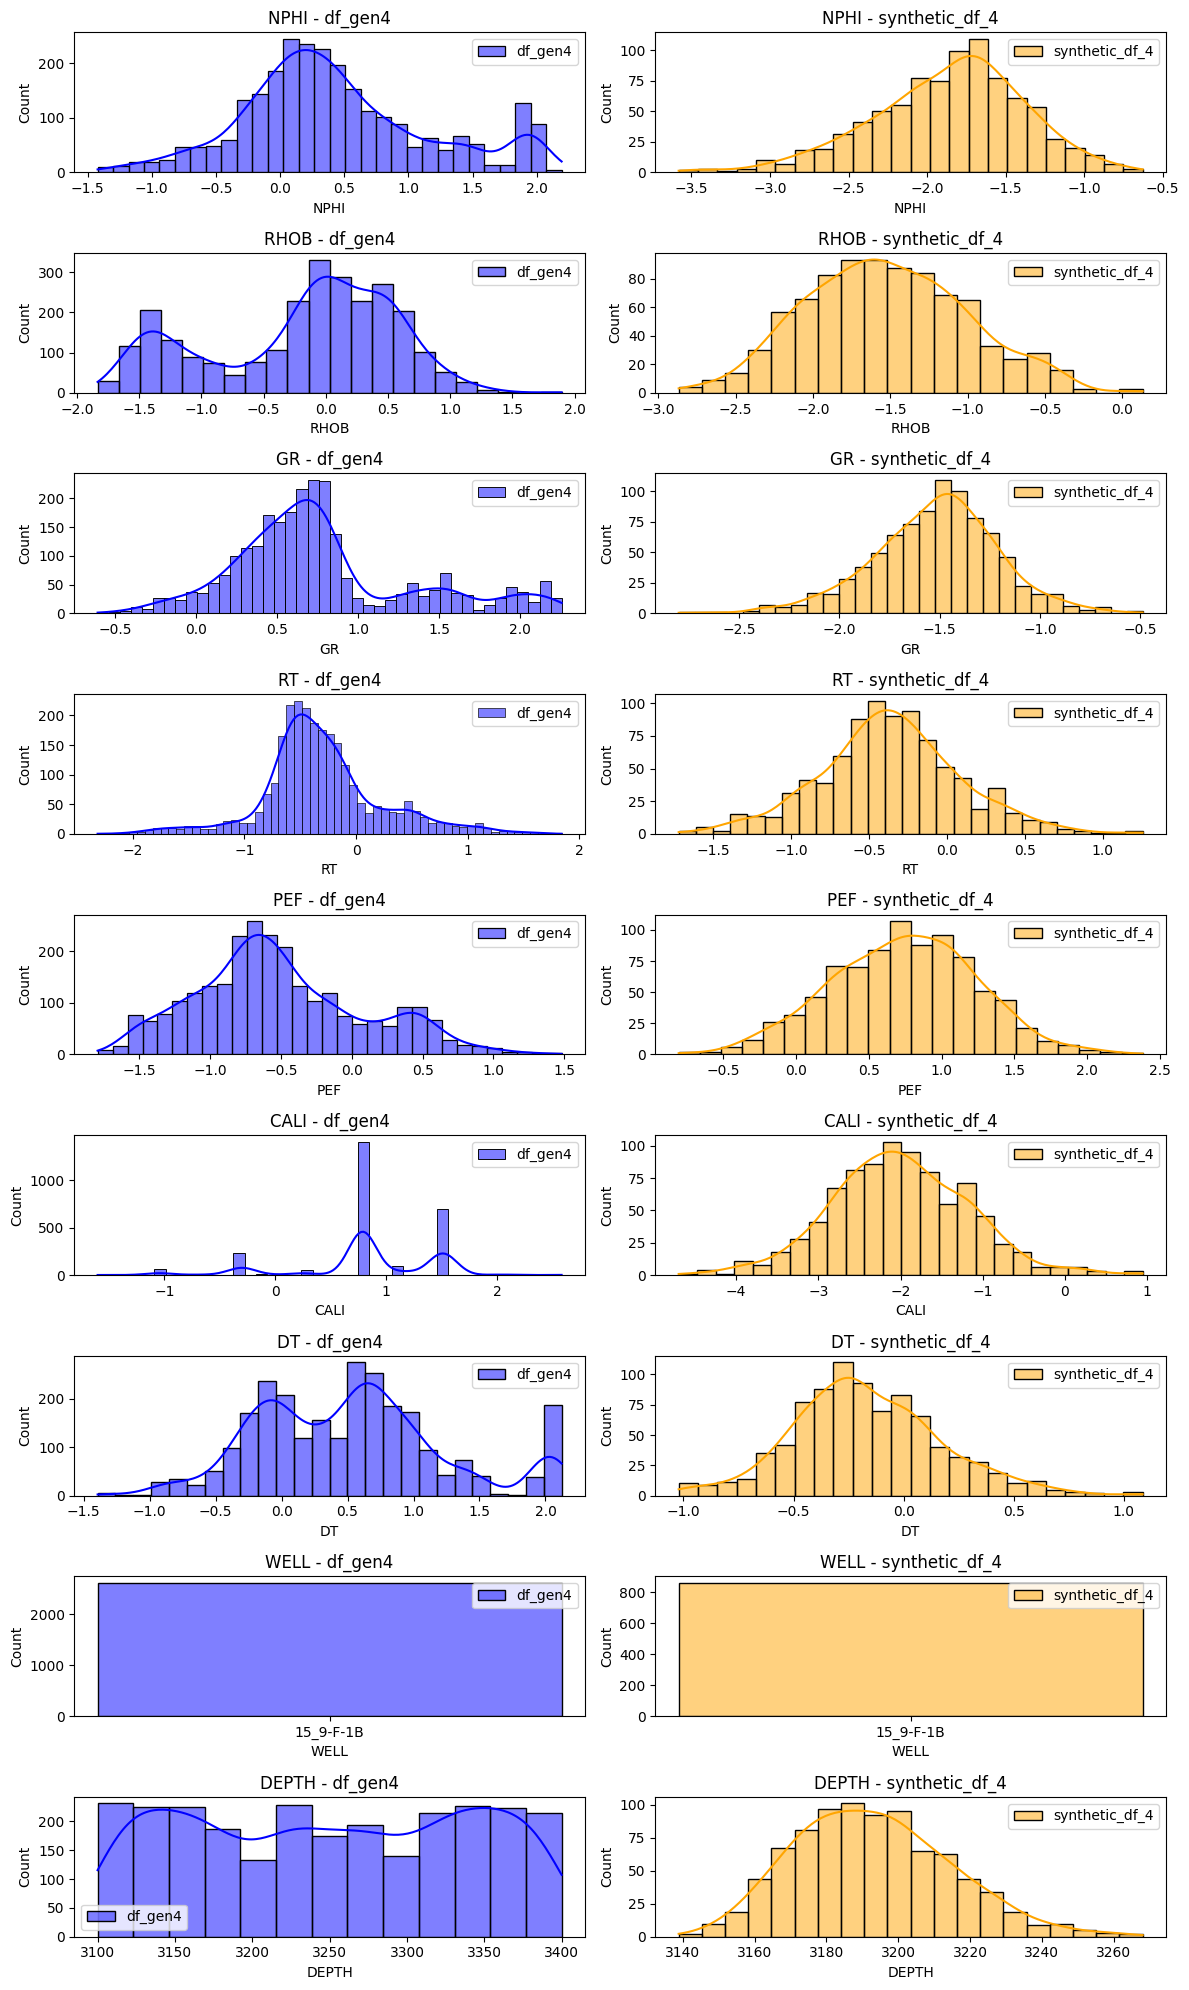

In [54]:
fig, axes = plt.subplots(nrows=len(df_gen4.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_4
for i, column in enumerate(df_gen4.columns):
    sns.histplot(df_gen4[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen4')
    axes[i, 0].set_title(f'{column} - df_gen4')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_4[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_4')
    axes[i, 1].set_title(f'{column} - synthetic_df_4')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [55]:
df_gen1 = pd.concat([df_gen1, synthetic_df_1])
df_gen1 = df_gen1.sort_values(by='DEPTH')

df_gen3 = pd.concat([df_gen1, synthetic_df_3])
df_gen3  = df_gen3.sort_values(by='DEPTH')

df_gen4 = pd.concat([df_gen1, synthetic_df_4])
df_gen4 = df_gen4.sort_values(by='DEPTH')


In [56]:
X_train_new = pd.concat([df_gen1, df_gen3, df_gen4])
y_train_new = X_train_new['DT']
X_train_new.drop(['DT', 'WELL', 'DEPTH'], axis = 1, inplace= True)

y_train_new = y_train_new.values.reshape(-1,1).astype('float32')
X_train_new = X_train_new.values.astype('float32')

### Decison Tree Regressor


In [57]:
# Decision Tree Regressor object
model_decision_tree = DecisionTreeRegressor()

# Fit the regressor to the training data
model_decision_tree.fit(X_train_new, y_train_new)

# Validation: Predict on well 1
y_pred1_decision_tree = model_decision_tree.predict(X_val1)
print("R2 Log 1: {}".format(round(model_decision_tree.score(X_val1, y_val1), 4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_decision_tree))
print("RMSE Log 1: {}".format(round(rmse, 4)))

# Validation: Predict on well 3
y_pred3_decision_tree = model_decision_tree.predict(X_val3)
print("R2 Log 3: {}".format(round(model_decision_tree.score(X_val3, y_val3), 4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_decision_tree))
print("RMSE Log 3: {}".format(round(rmse, 4)))

# Validation: Predict on well 4
y_pred4_decision_tree = model_decision_tree.predict(X_val4)
print("R2 Log 4: {}".format(round(model_decision_tree.score(X_val4, y_val4), 4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_decision_tree))
print("RMSE Log 4: {}".format(round(rmse, 4)))


R2 Log 1: 0.9792
RMSE Log 1: 0.1549
R2 Log 3: 0.8151
RMSE Log 3: 0.3977
R2 Log 4: 0.7595
RMSE Log 4: 0.3737


### Gradient Booster Regressor

In [58]:
# Gradient Booster object
model_grad_boost = GradientBoostingRegressor()

# Fit the regressor to the training data
model_grad_boost.fit(X_train_new, y_train_new)

# Validation: Predict on well 1
y_pred1_grad_boost = model_grad_boost.predict(X_val1)
print("R2 Log 1: {}".format(round(model_grad_boost.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_grad_boost))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3_grad_boost = model_grad_boost.predict(X_val3)
print("R2 Log 3: {}".format(round(model_grad_boost.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_grad_boost))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4_grad_boost = model_grad_boost.predict(X_val4)
print("R2 Log 4: {}".format(round(model_grad_boost.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_grad_boost))
print("RMSE Log 4: {}".format(round(rmse,4)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 Log 1: 0.9478
RMSE Log 1: 0.2453
R2 Log 3: 0.8873
RMSE Log 3: 0.3104
R2 Log 4: 0.8133
RMSE Log 4: 0.3292


### Neural Network

In [59]:
# Define the neural network model
def neural_network_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    return model

# Initialize and compile the neural network model
model_nn = neural_network_model(X_train_new.shape[1:])
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Fit the neural network model to the training data
history_nn = model_nn.fit(X_train_new, y_train_new, epochs=16, batch_size=1024, validation_data=(X_val1, y_val1))

# Validation: Predict on well 1
y_pred1_nn = model_nn.predict(X_val1)
rmse_nn1 = np.sqrt(mean_squared_error(y_val1, y_pred1_nn))
print("RMSE Neural Network Log 1: {}".format(round(rmse_nn1, 4)))

# Validation: Predict on well 3
y_pred3_nn = model_nn.predict(X_val3)
rmse_nn3 = np.sqrt(mean_squared_error(y_val3, y_pred3_nn))
print("RMSE Neural Network Log 3: {}".format(round(rmse_nn3, 4)))

# Validation: Predict on well 4
y_pred4_nn = model_nn.predict(X_val4)
rmse_nn4 = np.sqrt(mean_squared_error(y_val4, y_pred4_nn))
print("RMSE Neural Network Log 4: {}".format(round(rmse_nn4, 4)))


Epoch 1/16
1397/1397 [==============================] - 4s 2ms/step - loss: 0.0453 - val_loss: 0.0762
Epoch 2/16
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0317 - val_loss: 0.0588
Epoch 3/16
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0299 - val_loss: 0.0666
Epoch 4/16
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0291 - val_loss: 0.0594
Epoch 5/16
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0282 - val_loss: 0.0598
Epoch 6/16
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0275 - val_loss: 0.0570
Epoch 7/16
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0270 - val_loss: 0.0516
Epoch 8/16
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0262 - val_loss: 0.0508
Epoch 9/16
1397/1397 [==============================] - 3s 2ms/step - loss: 0.0259 - val_loss: 0.0464
Epoch 10/16
1397/1397 [==============================] - 3s 2ms/step - loss: 0.025

### LSTM

In [60]:
# Preparing data for LSTM
time_steps = 10

def prep_for_lstm(X_in, y_in, time_steps = 10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X_in) - time_steps):
        X_lstm.append(X_in[i:i+time_steps])
        y_lstm.append(y_in[i+time_steps])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    return X_lstm, y_lstm

X_train_lstm, y_train_lstm = prep_for_lstm(X_train_new, y_train_new, time_steps = time_steps)
X_val1_lstm, y_val1_lstm = prep_for_lstm(X_val1, y_val1, time_steps = time_steps)
X_val3_lstm, y_val3_lstm = prep_for_lstm(X_val3, y_val3, time_steps = time_steps)
X_val4_lstm, y_val4_lstm = prep_for_lstm(X_val4, y_val4, time_steps = time_steps)


In [61]:
y_train_lstm.shape

(44671, 1)

In [63]:
# Define bidirectional LSTM model with three layers
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(units=64)))
model_lstm.add(Dense(units=1))  # Output layer
model_lstm.compile(optimizer=Adam(), loss='mean_squared_error')

# Fit the LSTM model to the training data
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=16, batch_size=1024, validation_data=(X_val1_lstm, y_val1_lstm))

# Validation: Predict on well 1
y_pred1_lstm = model_lstm.predict(X_val1_lstm)
rmse_lstm1 = np.sqrt(mean_squared_error(y_val1_lstm, y_pred1_lstm))
print("RMSE LSTM Log 1: {}".format(round(rmse_lstm1, 4)))

# Validation: Predict on well 3
y_pred3_lstm = model_lstm.predict(X_val3_lstm)
rmse_lstm3 = np.sqrt(mean_squared_error(y_val3_lstm, y_pred3_lstm))
print("RMSE LSTM Log 3: {}".format(round(rmse_lstm3, 4)))

# Validation: Predict on well 4
y_pred4_lstm = model_lstm.predict(X_val4_lstm)
rmse_lstm4 = np.sqrt(mean_squared_error(y_val4_lstm, y_pred4_lstm))
print("RMSE LSTM Log 4: {}".format(round(rmse_lstm4, 4)))


Epoch 1/16
44/44 [==============================] - 46s 697ms/step - loss: 0.2982 - val_loss: 0.1409
Epoch 2/16
44/44 [==============================] - 23s 527ms/step - loss: 0.2370 - val_loss: 0.1702
Epoch 3/16
44/44 [==============================] - 22s 503ms/step - loss: 0.2302 - val_loss: 0.1600
Epoch 4/16
44/44 [==============================] - 26s 599ms/step - loss: 0.2254 - val_loss: 0.1246
Epoch 5/16
44/44 [==============================] - 24s 551ms/step - loss: 0.2204 - val_loss: 0.1044
Epoch 6/16
44/44 [==============================] - 23s 534ms/step - loss: 0.2180 - val_loss: 0.0876
Epoch 7/16
44/44 [==============================] - 23s 536ms/step - loss: 0.2163 - val_loss: 0.0737
Epoch 8/16
44/44 [==============================] - 23s 516ms/step - loss: 0.2148 - val_loss: 0.0910
Epoch 9/16
44/44 [==============================] - 22s 503ms/step - loss: 0.2121 - val_loss: 0.1070
Epoch 10/16
44/44 [==============================] - 27s 611ms/step - loss: 0.2111 - val_lo

### Formatting back the predictions

In [64]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1 = scaler.inverse_transform(y_val1.reshape(-1,1))
y_val3 = scaler.inverse_transform(y_val3.reshape(-1,1))
y_val4 = scaler.inverse_transform(y_val4.reshape(-1,1))


# Define a list to hold all predictions
all_predictions = [y_pred1_grad_boost, y_pred3_grad_boost, y_pred4_grad_boost,
                   y_pred1_nn, y_pred3_nn, y_pred4_nn,
                   y_pred1_lstm, y_pred3_lstm, y_pred4_lstm,
                   y_pred1_decision_tree, y_pred3_decision_tree, y_pred4_decision_tree
                   ]

# Inverse transform all predictions
all_predictions_inverse = [scaler.inverse_transform(pred.reshape(-1, 1)) for pred in all_predictions]

# Split the transformed predictions back into separate variables
(
    y_pred1_grad_boost_inv,  y_pred3_grad_boost_inv, y_pred4_grad_boost_inv,
    y_pred1_nn_inv, y_pred3_nn_inv, y_pred4_nn_inv,
    y_pred1_lstm_inv, y_pred3_lstm_inv, y_pred4_lstm_inv,
    y_pred1_decision_tree_inv, y_pred3_decision_tree_inv, y_pred4_decision_tree_inv
) = all_predictions_inverse

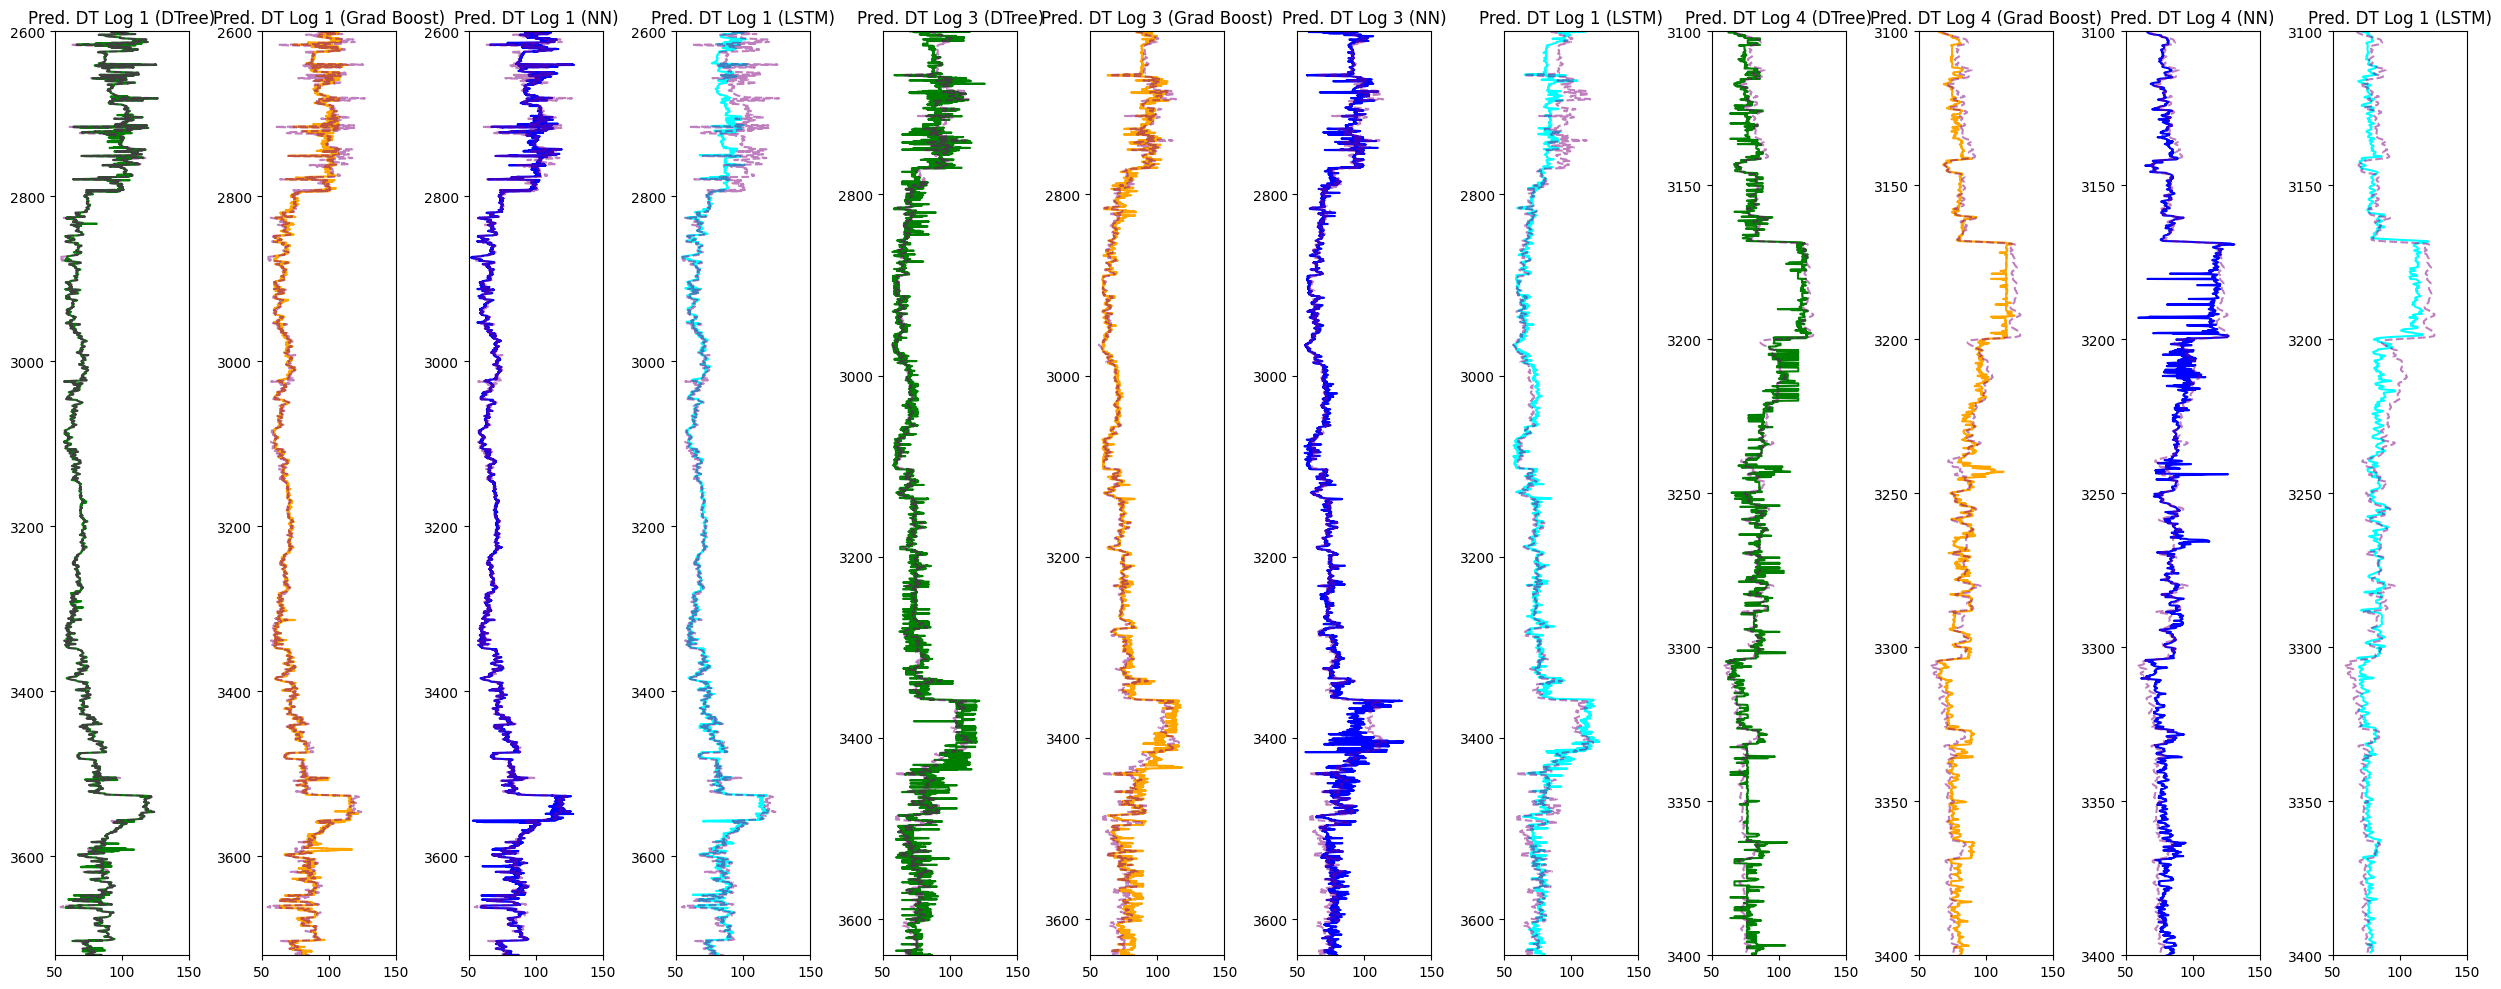

In [65]:
x_plott = [y_pred1_decision_tree_inv, y_pred1_grad_boost_inv, y_pred1_nn_inv,  y_pred1_lstm_inv,
           y_pred3_decision_tree_inv, y_pred3_grad_boost_inv, y_pred3_nn_inv,  y_pred3_lstm_inv,
           y_pred4_decision_tree_inv, y_pred4_grad_boost_inv, y_pred4_nn_inv,  y_pred4_lstm_inv]

x_real_plott = [
    y_val1,
    y_val3,
    y_val4
]

x_real_plott_lstm = [
    y_val1_lstm,
    y_val3_lstm,
    y_val4_lstm
]

y_plott = [log1['DEPTH'],
           log3['DEPTH'],
           log4['DEPTH']]

color_preds = ['green', 'orange', 'blue', 'cyan'] * 3
title_preds = ['Pred. DT Log 1 (DTree)', 'Pred. DT Log 1 (Grad Boost)', 'Pred. DT Log 1 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 3 (DTree)', 'Pred. DT Log 3 (Grad Boost)', 'Pred. DT Log 3 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 4 (DTree)', 'Pred. DT Log 4 (Grad Boost)', 'Pred. DT Log 4 (NN)',  'Pred. DT Log 1 (LSTM)',]

fig, ax = plt.subplots(nrows=1, ncols=12, figsize=(25, 10))

for i, (x_pred, title) in enumerate(zip(x_plott, title_preds)):
    # Reshape y[i] to match the shape of x_pred
    y_i_reshaped = y_plott[i//4]
    ax[i].plot(x_pred, y_i_reshaped[:len(x_pred)], color=color_preds[i])
    ax[i].plot(x_real_plott[i//4], y_i_reshaped, color='purple', linestyle='dashed', alpha = 0.5) #if i%4 != 0 else x_real_plott_lstm[i//4]
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(max(y_i_reshaped), min(y_i_reshaped))  # Ensure correct order of y-axis
    ax[i].set_title(title)

plt.tight_layout()
plt.show()


In [66]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [67]:
X_test2

array([[ 0.075,  2.605,  9.348,  8.331,  7.451,  8.547],
       [ 0.077,  2.602,  9.362,  8.289,  7.464,  8.547],
       [ 0.078,  2.599,  9.545,  8.247,  7.405,  8.547],
       ...,
       [ 0.103,  2.592, 32.217,  4.232,  4.729,  8.734],
       [ 0.108,  2.583, 29.841,  4.233,  4.705,  8.75 ],
       [ 0.114,  2.571, 31.423,  4.225,  4.617,  8.76 ]])

In [68]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

X_test2_lstm, _ = prep_for_lstm(X_test2, X_test2, time_steps = time_steps)
X_test5_lstm, _ = prep_for_lstm(X_test5, X_test5, time_steps = time_steps)


# Predictions for log 2 using all models
y_pred2_grad_boost = model_grad_boost.predict(X_test2)
y_pred2_decision_tree = model_decision_tree.predict(X_test2)
y_pred2_nn = model_nn.predict(X_test2)
y_pred2_lstm = model_lstm.predict(X_test2_lstm)
#y_pred2_transformer = model_transformer.predict(X_test2)

# Predictions for log 5 using all models
y_pred5_grad_boost = model_grad_boost.predict(X_test5)
y_pred5_decision_tree = model_decision_tree.predict(X_test5)
y_pred5_nn = model_nn.predict(X_test5)
y_pred5_lstm = model_lstm.predict(X_test5_lstm)
#y_pred5_transformer = model_transformer.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred for log 2
y_pred2_grad_boost = scaler.inverse_transform(y_pred2_grad_boost.reshape(-1,1))
y_pred2_decision_tree = scaler.inverse_transform(y_pred2_decision_tree.reshape(-1,1))
y_pred2_nn = scaler.inverse_transform(y_pred2_nn.reshape(-1,1))
y_pred2_lstm = scaler.inverse_transform(y_pred2_lstm.reshape(-1,1))
#y_pred2_transformer = scaler.inverse_transform(y_pred2_transformer.reshape(-1,1))

# Inverse transform y_pred for log 5
y_pred5_grad_boost = scaler.inverse_transform(y_pred5_grad_boost.reshape(-1,1))
y_pred5_decision_tree = scaler.inverse_transform(y_pred5_decision_tree.reshape(-1,1))
y_pred5_nn = scaler.inverse_transform(y_pred5_nn.reshape(-1,1))
y_pred5_lstm = scaler.inverse_transform(y_pred5_lstm.reshape(-1,1))
#y_pred5_transformer = scaler.inverse_transform(y_pred5_transformer.reshape(-1,1))


297/297 [==============================] - 3s 11ms/step


In [69]:
def pad_predicted_values(predicted_values, target_column, window_size=10):
    """
    Pad the predicted values using a moving average to fill in the gaps.

    Parameters:
        predicted_values (np.ndarray): The predicted values to pad.
        target_column (pd.Series): The target column used to calculate moving average.
        window_size (int): The size of the moving average window.

    Returns:
        np.ndarray: The padded predicted values.
    """
    # Calculate the number of values to pad
    pad_length = len(target_column) - len(predicted_values)

    # Pad the predicted values with NaNs to match the length of target_column
    padding = np.full((pad_length, 1), np.nan)

    padded_values = np.concatenate((padding, predicted_values))

    for i in range(len(padded_values)-1, -1, -1):
        if np.isnan(padded_values[i][0]):
            padded_values[i][0] = np.mean(padded_values[i+1:i+1+window_size])



    return padded_values


In [70]:
y_pred2_lstm

array([[65.827484],
       [66.04312 ],
       [66.26528 ],
       ...,
       [72.121635],
       [71.909355],
       [71.789635]], dtype=float32)

In [71]:
pad_predicted_values(y_pred2_lstm, y_pred2_nn)

array([[66.38712915],
       [66.35585571],
       [66.34762171],
       ...,
       [72.12163544],
       [71.90935516],
       [71.7896347 ]])

In [72]:
# Add predictions for log 2 to the dataframes
log2['DT_grad_boost'] = y_pred2_grad_boost
log2['DT_Tree'] = y_pred2_decision_tree
log2['DT_nn'] = y_pred2_nn
log2['DT_lstm'] = pad_predicted_values(y_pred2_lstm, log2['DT_Tree'])


# Add predictions for log 5 to the dataframes
log5['DT_grad_boost'] = y_pred5_grad_boost
log5['DT_Tree'] = y_pred5_decision_tree
log5['DT_nn'] = y_pred5_nn
log5['DT_lstm'] = pad_predicted_values(y_pred5_lstm, log5['DT_Tree'])
#log5['DT_transformer'] = y_pred5_transformer


<ipython-input-72-b0e2fc4a4f3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_grad_boost'] = y_pred5_grad_boost
<ipython-input-72-b0e2fc4a4f3b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_Tree'] = y_pred5_decision_tree
<ipython-input-72-b0e2fc4a4f3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

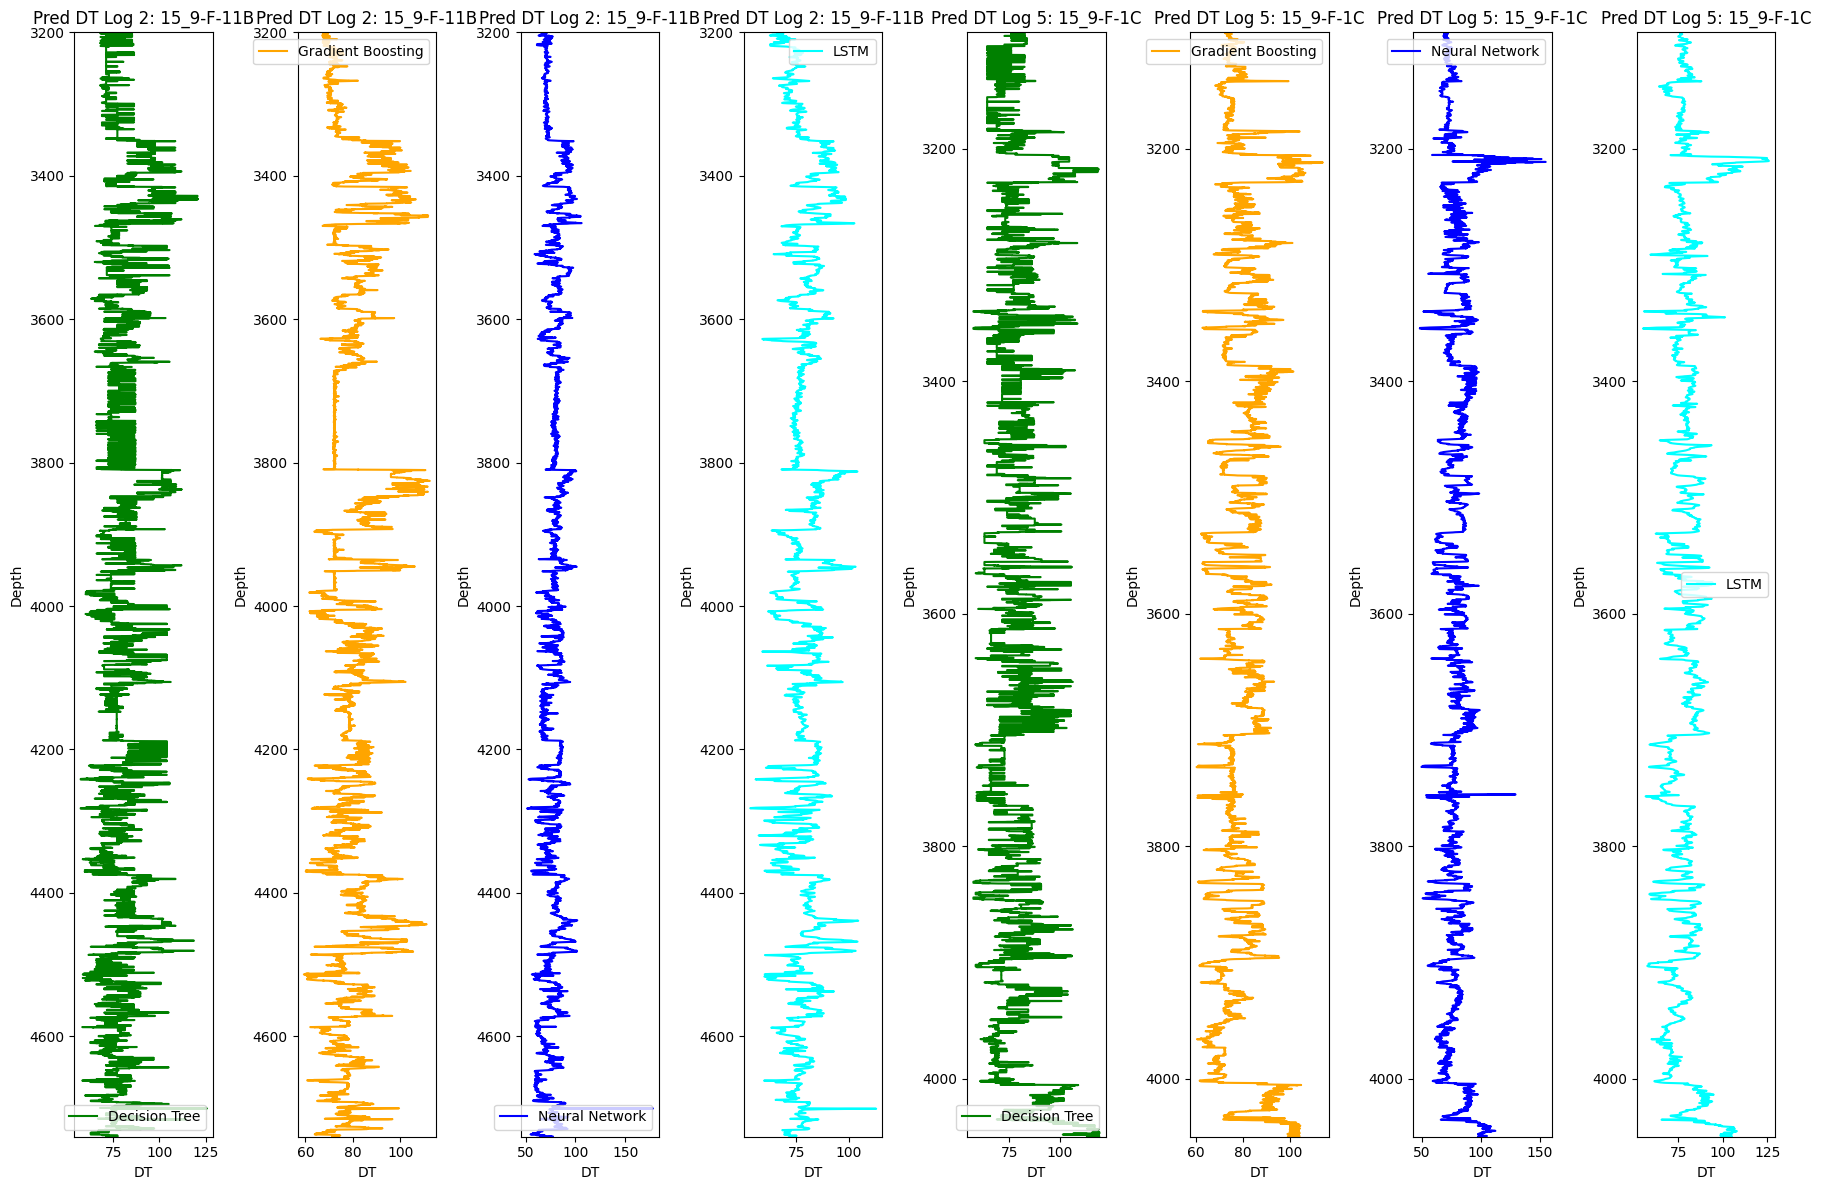

In [77]:
plt.figure(figsize=(18, 12))

# Plot predictions for log 2

plt.subplot(1, 8, 1)
plt.plot(y_pred2_decision_tree, depth2, color='green', label='Decision Tree')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 2)
plt.plot(y_pred2_grad_boost, depth2, color='orange', label='Gradient Boosting')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 3)
plt.plot(y_pred2_nn, depth2, color='blue', label='Neural Network')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 4)
plt.plot(pad_predicted_values(y_pred2_lstm, depth2), depth2, color='cyan', label='LSTM')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

# For log 5

plt.subplot(1, 8, 5)
plt.plot(y_pred5_decision_tree, depth5, color='green', label='Decision Tree')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 6)
plt.plot(y_pred5_grad_boost, depth5, color='orange', label='Gradient Boosting')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 7)
plt.plot(y_pred5_nn, depth5, color='blue', label='Neural Network')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 8)
plt.plot(pad_predicted_values(y_pred5_lstm, depth5), depth5, color='cyan', label='LSTM')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.tight_layout()
plt.show()


In [74]:
def makeplotpred(df, color_list, suptitle_str="Pass a suptitle"):
    # Column selection from df
    col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT_Tree', 'DT_grad_boost', 'DT_nn', 'DT_lstm']
    # Plotting titles
    title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT Decsion Tree', 'Predicted DT GB', 'Predicted DT NN', 'Predicted DT LSTM']

    # Create the subplots; ncols equals the number of logs
    fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(20,15))
    fig.suptitle(suptitle_str, size=20, y=1.05)

    # Looping each log to display in the subplots
    for i in range(len(col_names)):
        if i == 3:
            # for resistivity, semilog plot
            ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=color_list[i])

        else:
            # for non-resistivity, normal plot
            ax[i].plot(df[col_names[i]], df['DEPTH'], color=color_list[i])

        ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
        ax[i].set_title(title[i], pad=15)
        ax[i].grid(True)
        ax[i].legend()

    ax[2].set_xlim(0, 200)
    plt.tight_layout()
    plt.show()

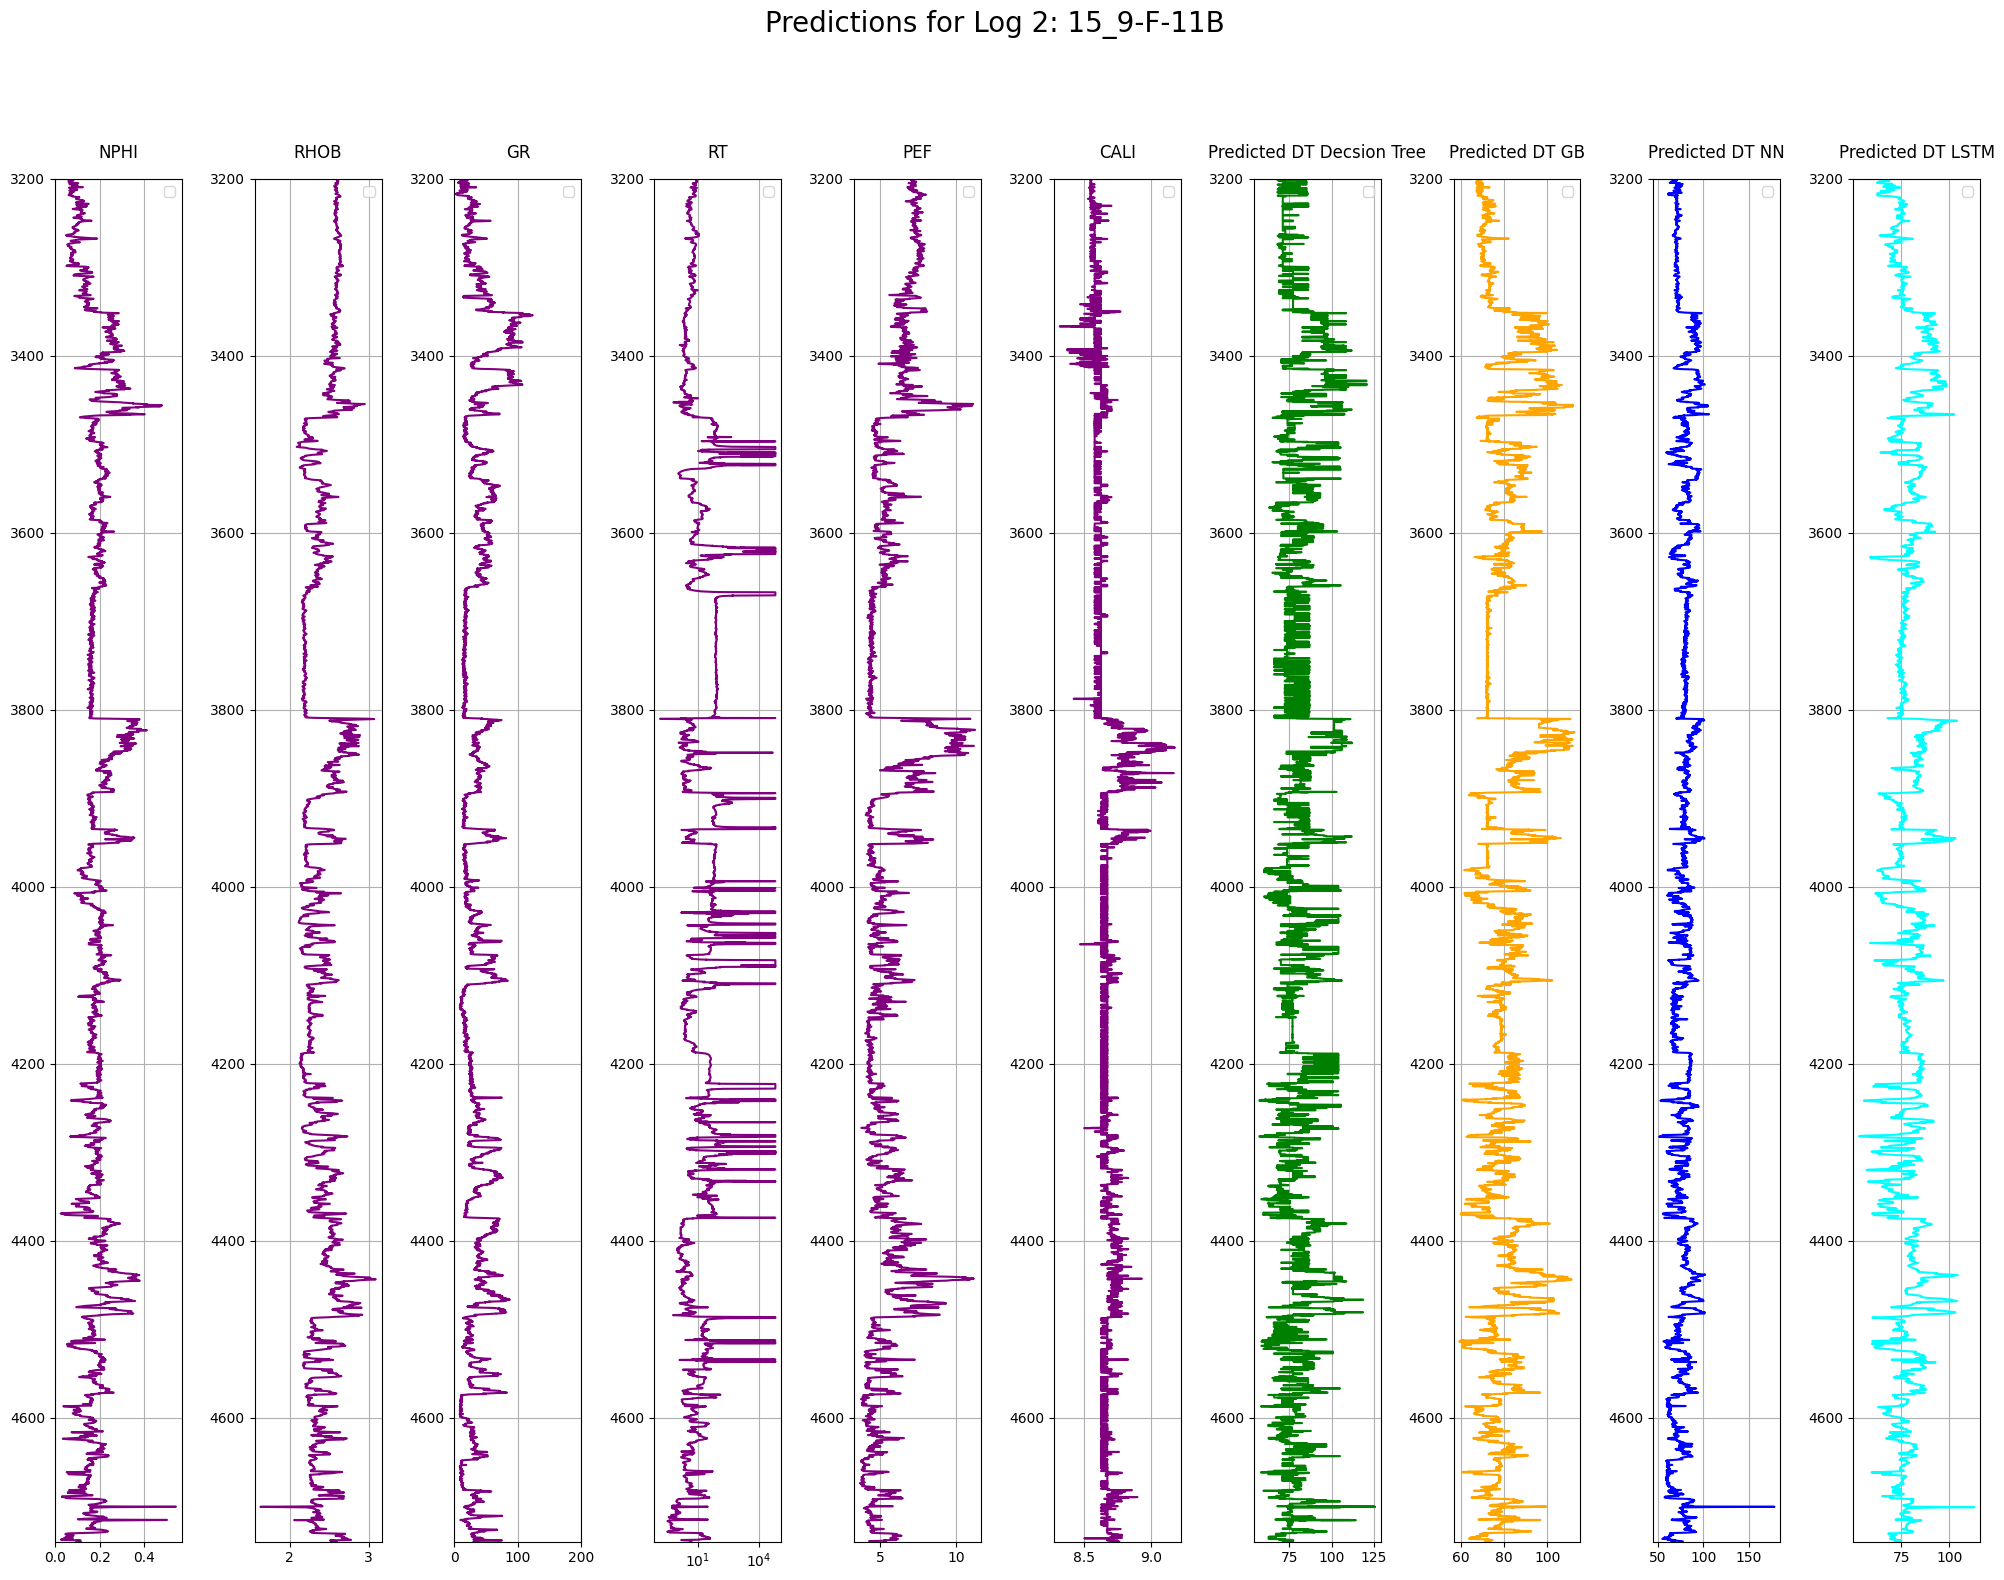

In [78]:
# Assuming `depth` is the depth information shared among all logs
makeplotpred(log2,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 2: 15_9-F-11B")

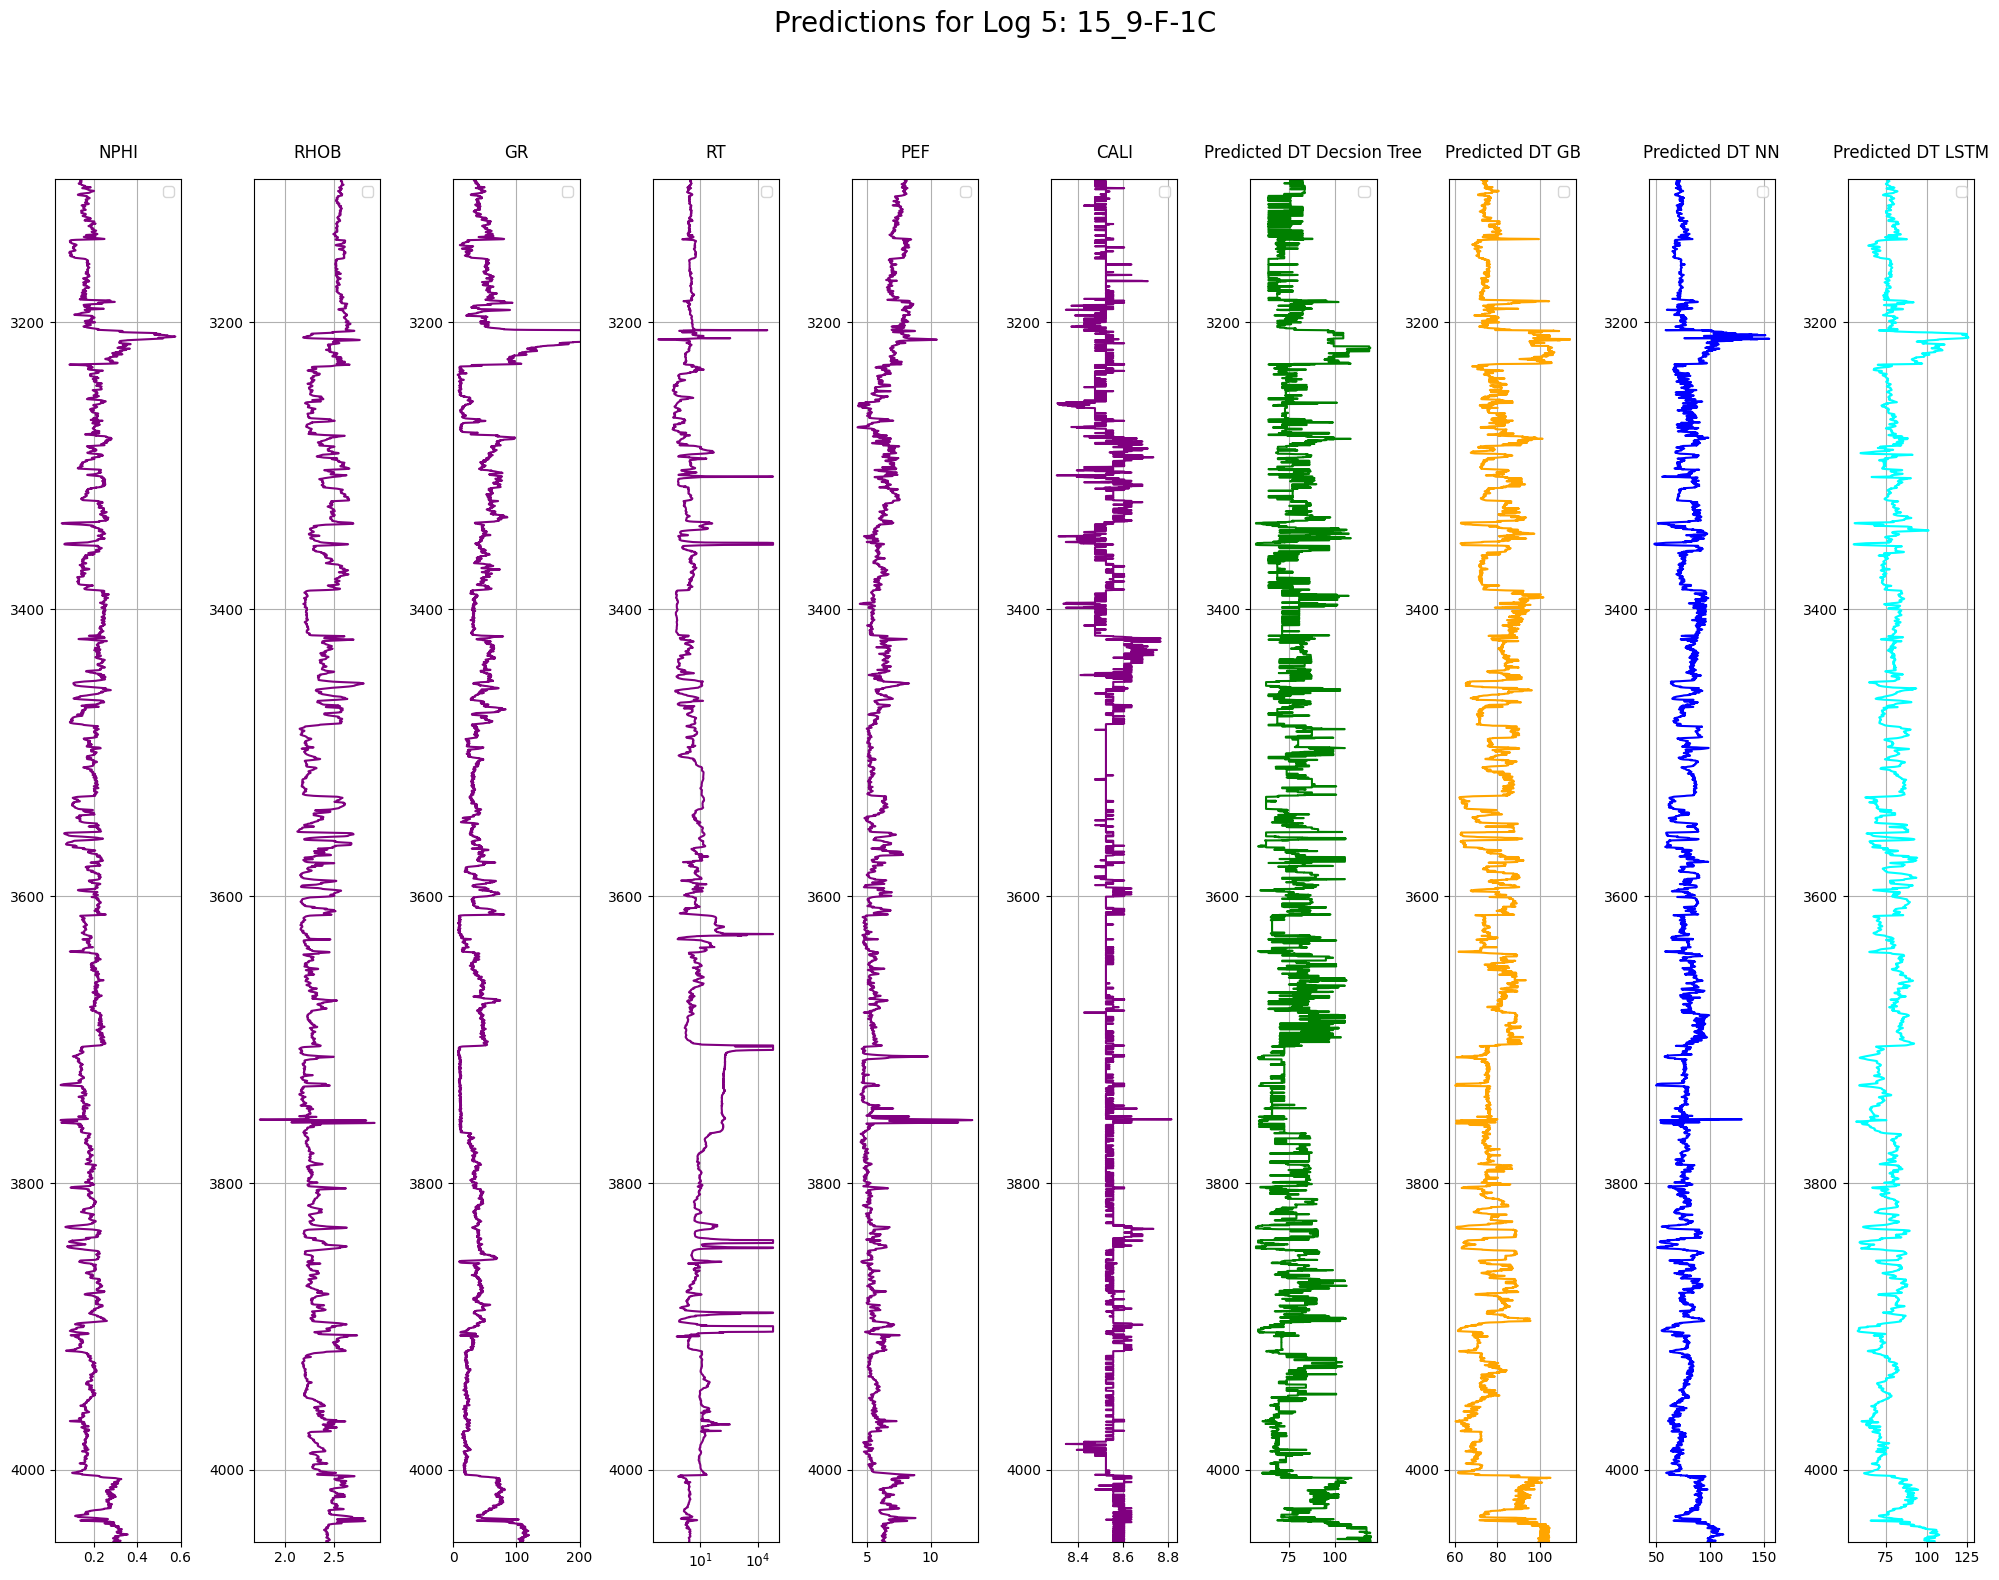

In [79]:
makeplotpred(log5,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 5: 15_9-F-1C")